
# Informe de Proyecto: Generador Adversarial de Redes Convolucionales Profundas (DCGAN) Entrenado en CelebA

`Nombre del Estudiante:` Emiliano Rodríguez

`Materia:` Deep Learning

`Fecha`: 11 de abril, a las 8:00 PM

#### Introducción

En este proyecto, se implementó una Generative Adversarial Network (GAN) utilizando redes convolucionales profundas (DCGAN) para el conjunto de datos CelebA. CelebA es un conjunto de datos de imágenes de caras de celebridades, ampliamente utilizado en la investigación de aprendizaje automático y visión por computadora. El objetivo principal fue generar imágenes realistas de caras de celebridades a partir de datos de entrada aleatorios.

#### Modelo Generativo Adversarial (GAN)

Un Generative Adversarial Network (GAN) es un modelo de aprendizaje profundo que consta de dos redes neuronales, un generador y un discriminador, que compiten entre sí en un juego adversarial. El generador aprende a generar muestras sintéticas que son indistinguibles de las muestras reales, mientras que el discriminador aprende a distinguir entre las muestras reales y las generadas por el generador.

#### Implementación con PyTorch en CelebA

Para implementar un DCGAN en CelebA, se utilizaron las siguientes etapas:

* Preprocesamiento de datos: Las imágenes en CelebA se redimensionaron y normalizaron para su procesamiento.
* Definición del generador y el discriminador: Se definieron dos redes convolucionales profundas en PyTorch, una para el generador y otra para el discriminador.
* Entrenamiento del modelo: Se entrenaron las redes alternativamente, actualizando los pesos del generador y el discriminador para mejorar la calidad de las imágenes generadas.
* Evaluación del modelo: Se evaluó la calidad de las imágenes generadas visualmente y mediante métricas de evaluación de calidad de imagen.


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import zipfile
import os
from torchvision import datasets
import matplotlib.colors as mcolors
import random
import torch.nn.functional as F
import time
import torch.autograd
import shutil
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import sampler

In [24]:
def get_dataloaders_celeba(batch_size, num_workers=0,
                           train_transforms=None,
                           test_transforms=None,
                           download=True,
                           data_dir='/content/drive/MyDrive/ITESO/APRENDIZAJE_PROFUNDO/proyecto_VAE/'):

    # Si no se especifican las transformaciones para el conjunto de entrenamiento, se convierten a tensores
    if train_transforms is None:
        train_transforms = transforms.ToTensor()

    # Si no se especifican las transformaciones para el conjunto de prueba, se convierten a tensores
    if test_transforms is None:
        test_transforms = transforms.ToTensor()

    # Descomprime el archivo si aún no ha sido descomprimido
    if not os.path.exists(os.path.join(data_dir, 'Archive_2')):
        with zipfile.ZipFile(os.path.join(data_dir, 'Archive_2.zip'), 'r') as zip_ref:
            zip_ref.extractall(data_dir)

    # Carga los conjuntos de datos de entrenamiento, validación y prueba
    train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'Archive_2'),
                                         transform=train_transforms)

    valid_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'Archive_2'),
                                         transform=test_transforms)

    test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'Archive_2'),
                                        transform=test_transforms)

    # Crea los DataLoader para cada conjunto de datos
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=True)

    valid_loader = DataLoader(dataset=valid_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=False)

    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)

    return train_loader, valid_loader, test_loader

# Establece la semilla aleatoria para asegurar reproducibilidad
def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    torch.set_deterministic(True)

# Establece la semilla aleatoria en todas las bibliotecas para asegurar reproducibilidad
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Calcula la precisión del modelo
def compute_accuracy(model, data_loader, device):
    model.eval()
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        for i, (features, targets) in enumerate(data_loader):
            features = features.to(device)
            targets = targets.to(device)
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

# Calcula la pérdida de la época para un clasificador
def compute_epoch_loss_classifier(model, data_loader, loss_fn, device):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(device)
            targets = targets.to(device)
            logits = model(features)
            loss = loss_fn(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss
        curr_loss = curr_loss / num_examples
        return curr_loss

# Calcula la pérdida de la época para un autoencoder
def compute_epoch_loss_autoencoder(model, data_loader, loss_fn, device):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, _ in data_loader:
            features = features.to(device)
            logits = model(features)
            loss = loss_fn(logits, features, reduction='sum')
            num_examples += features.size(0)
            curr_loss += loss
        curr_loss = curr_loss / num_examples
        return curr_loss

# Entrena una GAN durante un número dado de épocas
def train_gan_v1(num_epochs, model, optimizer_gen, optimizer_discr,
                 latent_dim, device, train_loader, loss_fn=None,
                 logging_interval=100,
                 save_model=None):

    # Diccionario para almacenar los registros de entrenamiento
    log_dict = {'train_generator_loss_per_batch': [],
                'train_discriminator_loss_per_batch': [],
                'train_discriminator_real_acc_per_batch': [],
                'train_discriminator_fake_acc_per_batch': [],
                'images_from_noise_per_epoch': []}

    # Si no se especifica una función de pérdida, se usa la pérdida binaria de entropía cruzada
    if loss_fn is None:
        loss_fn = F.binary_cross_entropy_with_logits

    # Vector de ruido fijo para evaluar/visualizar el progreso del entrenamiento del generador
    fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):

            batch_size = features.size(0)

            real_images = features.to(device)
            real_labels = torch.ones(batch_size, device=device)

            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_images = model.generator_forward(noise)
            fake_labels = torch.zeros(batch_size, device=device)
            flipped_fake_labels = real_labels

            optimizer_discr.zero_grad()

            discr_pred_real = model.discriminator_forward(real_images).view(-1)
            real_loss = loss_fn(discr_pred_real, real_labels)

            discr_pred_fake = model.discriminator_forward(fake_images.detach()).view(-1)
            fake_loss = loss_fn(discr_pred_fake, fake_labels)

            discr_loss = 0.5*(real_loss + fake_loss)
            discr_loss.backward()
            optimizer_discr.step()

            optimizer_gen.zero_grad()

            discr_pred_fake = model.discriminator_forward(fake_images).view(-1)
            gener_loss = loss_fn(discr_pred_fake, flipped_fake_labels)
            gener_loss.backward()
            optimizer_gen.step()

            log_dict['train_generator_loss_per_batch'].append(gener_loss.item())
            log_dict['train_discriminator_loss_per_batch'].append(discr_loss.item())

            predicted_labels_real = torch.where(discr_pred_real.detach() > 0., 1., 0.)
            predicted_labels_fake = torch.where(discr_pred_fake.detach() > 0., 1., 0.)
            acc_real = (predicted_labels_real == real_labels).float().mean()*100.
            acc_fake = (predicted_labels_fake == fake_labels).float().mean()*100.
            log_dict['train_discriminator_real_acc_per_batch'].append(acc_real.item())
            log_dict['train_discriminator_fake_acc_per_batch'].append(acc_fake.item())

            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f'
                       % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), gener_loss.item(), discr_loss.item()))

        with torch.no_grad():
            fake_images = model.generator_forward(fixed_noise).detach().cpu()
            log_dict['images_from_noise_per_epoch'].append(
                torchvision.utils.make_grid(fake_images, padding=2, normalize=True))

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    if save_model is not None:
        torch.save(model.state_dict(), save_model)

    return log_dict


In [25]:
# Definir el dispositivo de ejecución (GPU si está disponible, de lo contrario, CPU)
CUDA_DEVICE_NUM = 2  # Número de GPU a utilizar
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hiperparámetros
RANDOM_SEED = 42  # Semilla aleatoria para reproducibilidad
GENERATOR_LEARNING_RATE = 0.0002  # Tasa de aprendizaje del generador
DISCRIMINATOR_LEARNING_RATE = 0.0002  # Tasa de aprendizaje del discriminador

NUM_EPOCHS = 6  # Número de épocas de entrenamiento
BATCH_SIZE = 128  # Tamaño del lote de datos para el entrenamiento

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 64, 64, 3  # Dimensiones de las imágenes de entrada


Device: cpu


In [26]:
set_deterministic
set_all_seeds(RANDOM_SEED)

## Dataset

In [27]:
def get_dataloaders_celeba(batch_size, num_workers=0,
                           train_transforms=None,
                           test_transforms=None,
                           zip_file='/content/drive/MyDrive/ITESO/APRENDIZAJE_PROFUNDO/vae_pasado/celebA.zip'):
    # Directorio de destino donde se extraerán los archivos
    extracted_folder = "/content/extracted_files"

    # Crear el directorio de destino si no existe
    os.makedirs(extracted_folder, exist_ok=True)

    # Descomprimir el archivo ZIP si no se ha descomprimido todavía
    if not os.path.exists(os.path.join(extracted_folder, 'img_align_celeba')):
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extracted_folder)
        print("Archivo descomprimido")

    # Eliminar la carpeta __MACOSX
    macosx_folder = os.path.join(extracted_folder, '__MACOSX')
    if os.path.exists(macosx_folder):
        shutil.rmtree(macosx_folder)
        print("Carpeta __MACOSX eliminada con éxito.")

    # Si no se especifican transformaciones de entrenamiento, utilizar ToTensor()
    if train_transforms is None:
        train_transforms = transforms.ToTensor()

    # Si no se especifican transformaciones de prueba, utilizar ToTensor()
    if test_transforms is None:
        test_transforms = transforms.ToTensor()

    # Crear conjuntos de datos utilizando ImageFolder
    train_dataset = datasets.ImageFolder(root=extracted_folder, transform=train_transforms)
    valid_dataset = datasets.ImageFolder(root=extracted_folder, transform=test_transforms)
    test_dataset = datasets.ImageFolder(root=extracted_folder, transform=test_transforms)

    # Crear cargadores de datos DataLoader
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

    return train_loader, valid_loader, test_loader

In [28]:
# Definir transformaciones personalizadas
custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((160, 160)),  # Recortar alrededor del centro
    torchvision.transforms.Resize([IMAGE_HEIGHT, IMAGE_WIDTH]),  # Redimensionar a altura y anchura especificadas
    torchvision.transforms.ToTensor(),  # Convertir la imagen a un tensor
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar los valores de píxeles
])

# Obtener cargadores de datos para el conjunto de datos CelebA
train_loader, valid_loader, test_loader = get_dataloaders_celeba(
    batch_size=BATCH_SIZE,
    train_transforms=custom_transforms,
    test_transforms=custom_transforms,
    num_workers=4)


Archivo descomprimido
Carpeta __MACOSX eliminada con éxito.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [29]:
print('Training Set:\n')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    break

print('\nValidation Set:')
for images, labels in valid_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    break

print('\nTesting Set:')
for images, labels in test_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    break

Training Set:

Image batch dimensions: torch.Size([128, 3, 64, 64])
Image label dimensions: torch.Size([128])

Validation Set:
Image batch dimensions: torch.Size([128, 3, 64, 64])
Image label dimensions: torch.Size([128])

Testing Set:
Image batch dimensions: torch.Size([128, 3, 64, 64])
Image label dimensions: torch.Size([128])


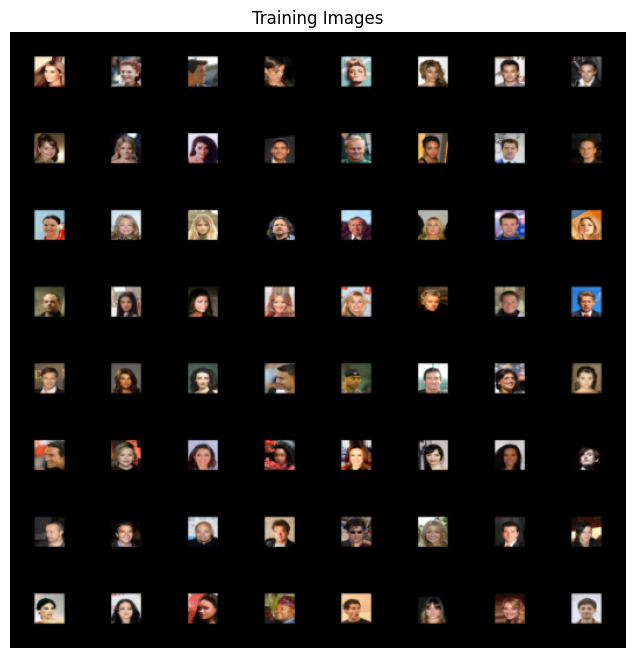

In [30]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64],
                                         padding=2, normalize=True),
                        (1, 2, 0)))

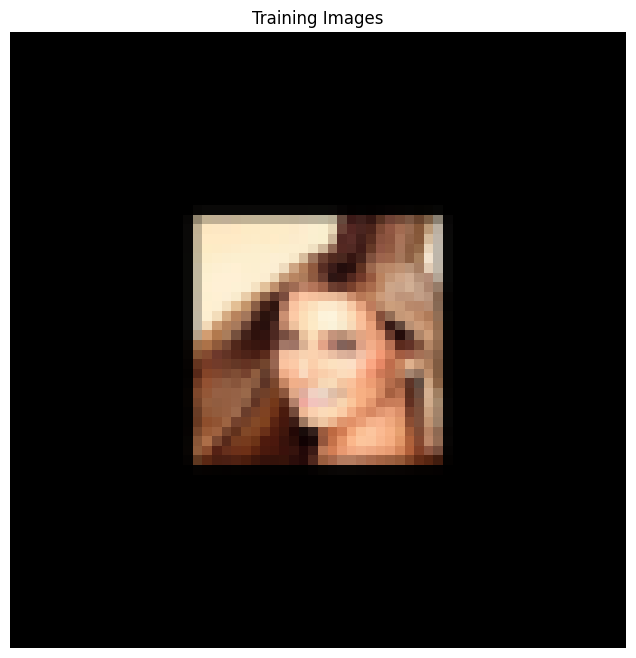

In [31]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[0],
                                         padding=2, normalize=True),
                        (1, 2, 0)))

## Model

In [32]:
class DCGAN(torch.nn.Module):

    def __init__(self, latent_dim=100,
                 num_feat_maps_gen=64, num_feat_maps_dis=64,
                 color_channels=3):
        super().__init__()

        # Generador
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, num_feat_maps_gen*8,
                               kernel_size=4, stride=1, padding=0,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*8),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(num_feat_maps_gen*8, num_feat_maps_gen*4,
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*4),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(num_feat_maps_gen*4, num_feat_maps_gen*2,
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*2),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(num_feat_maps_gen*2, num_feat_maps_gen,
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(num_feat_maps_gen, color_channels,
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.Tanh()
        )

        # Discriminador
        self.discriminator = nn.Sequential(
            nn.Conv2d(color_channels, num_feat_maps_dis,
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(num_feat_maps_dis, num_feat_maps_dis*2,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),
            nn.BatchNorm2d(num_feat_maps_dis*2),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(num_feat_maps_dis*2, num_feat_maps_dis*4,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),
            nn.BatchNorm2d(num_feat_maps_dis*4),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(num_feat_maps_dis*4, num_feat_maps_dis*8,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),
            nn.BatchNorm2d(num_feat_maps_dis*8),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(num_feat_maps_dis*8, 1,
                      kernel_size=4, stride=1, padding=0),
            nn.Flatten(),
        )


    def generator_forward(self, z):
        img = self.generator(z)
        return img

    def discriminator_forward(self, img):
        logits = model.discriminator(img)
        return logits


In [33]:
# Establece todas las semillas para garantizar la reproducibilidad
set_all_seeds(RANDOM_SEED)

# Crea una instancia del modelo DCGAN y lo mueve al dispositivo (GPU o CPU)
model = DCGAN()
model.to(DEVICE)

# Define el optimizador para los parámetros del generador
optim_gen = torch.optim.Adam(model.generator.parameters(),
                             betas=(0.5, 0.999),
                             lr=GENERATOR_LEARNING_RATE)

# Define el optimizador para los parámetros del discriminador
optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                               betas=(0.5, 0.999),
                               lr=DISCRIMINATOR_LEARNING_RATE)


## Training

In [34]:
log_dict = train_gan_v1(num_epochs=NUM_EPOCHS, model=model,
                        optimizer_gen=optim_gen,
                        optimizer_discr=optim_discr,
                        latent_dim=100,
                        device=DEVICE,
                        train_loader=train_loader,
                        logging_interval=100,
                        save_model='gan_celeba_01.pt')

Epoch: 001/006 | Batch 000/235 | Gen/Dis Loss: 2.2724/0.6374
Epoch: 001/006 | Batch 100/235 | Gen/Dis Loss: 8.0697/0.0009
Epoch: 001/006 | Batch 200/235 | Gen/Dis Loss: 7.4345/0.0153
Time elapsed: 34.06 min
Epoch: 002/006 | Batch 000/235 | Gen/Dis Loss: 7.1005/0.0068
Epoch: 002/006 | Batch 100/235 | Gen/Dis Loss: 3.9061/0.4136
Epoch: 002/006 | Batch 200/235 | Gen/Dis Loss: 2.1923/0.3365
Time elapsed: 66.05 min
Epoch: 003/006 | Batch 000/235 | Gen/Dis Loss: 2.3049/0.3897
Epoch: 003/006 | Batch 100/235 | Gen/Dis Loss: 1.4418/0.3656
Epoch: 003/006 | Batch 200/235 | Gen/Dis Loss: 3.7723/0.5294
Time elapsed: 98.10 min
Epoch: 004/006 | Batch 000/235 | Gen/Dis Loss: 0.9726/0.5103
Epoch: 004/006 | Batch 100/235 | Gen/Dis Loss: 5.2637/0.7521
Epoch: 004/006 | Batch 200/235 | Gen/Dis Loss: 1.9121/0.3618
Time elapsed: 130.59 min
Epoch: 005/006 | Batch 000/235 | Gen/Dis Loss: 5.4580/0.4008
Epoch: 005/006 | Batch 100/235 | Gen/Dis Loss: 2.9680/0.2857
Epoch: 005/006 | Batch 200/235 | Gen/Dis Loss: 1.

## Evaluation

In [35]:
# Esta función traza múltiples curvas de pérdida de entrenamiento en un solo gráfico.
# Los datos de pérdida se pasan como una lista de tensores.
# Se puede especificar una lista de etiquetas personalizadas para cada curva de pérdida.

def plot_multiple_training_losses(losses_list, num_epochs,
                                  averaging_iterations=100, custom_labels_list=None):
    # Verifica que todos los tensores de pérdida tengan la misma longitud
    for i,_ in enumerate(losses_list):
        if not len(losses_list[i]) == len(losses_list[0]):
            raise ValueError('All loss tensors need to have the same number of elements.')

    # Si no se proporcionan etiquetas personalizadas, se crean automáticamente
    if custom_labels_list is None:
        custom_labels_list = [str(i) for i,_ in enumerate(custom_labels_list)]

    # Calcula la cantidad de iteraciones por época
    iter_per_epoch = len(losses_list[0]) // num_epochs

    # Configura el gráfico
    plt.figure()
    ax1 = plt.subplot(1, 1, 1)

    # Traza las curvas de pérdida para cada tensor en la lista
    for i, minibatch_loss_tensor in enumerate(losses_list):
        ax1.plot(range(len(minibatch_loss_tensor)),
                 (minibatch_loss_tensor),
                  label=f'Minibatch Loss{custom_labels_list[i]}')
        ax1.set_xlabel('Iterations')
        ax1.set_ylabel('Loss')

        # Traza una versión suavizada de la curva de pérdida
        ax1.plot(np.convolve(minibatch_loss_tensor,
                             np.ones(averaging_iterations,)/averaging_iterations,
                             mode='valid'),
                 color='black')

    # Ajusta los límites del eje y
    if len(losses_list[0]) < 1000:
        num_losses = len(losses_list[0]) // 2
    else:
        num_losses = 1000
    maxes = [np.max(losses_list[i][num_losses:]) for i,_ in enumerate(losses_list)]
    ax1.set_ylim([0, np.max(maxes)*1.5])
    ax1.legend()

    # Configura un segundo eje x para mostrar épocas en lugar de iteraciones
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))
    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())

    plt.tight_layout()


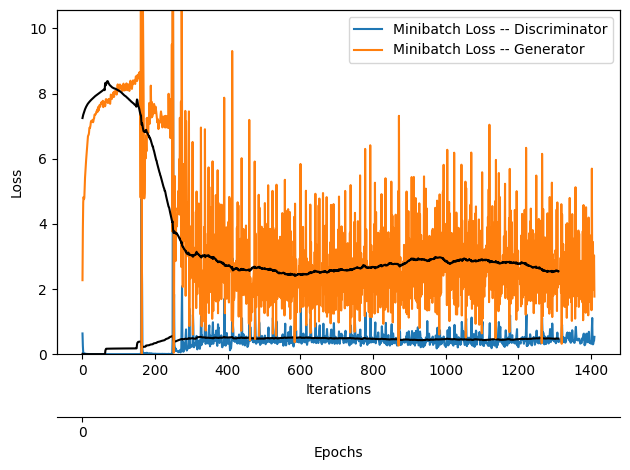

In [36]:
plot_multiple_training_losses(
    losses_list=(log_dict['train_discriminator_loss_per_batch'],
                 log_dict['train_generator_loss_per_batch']),
    num_epochs=NUM_EPOCHS,
    custom_labels_list=(' -- Discriminator', ' -- Generator')
)

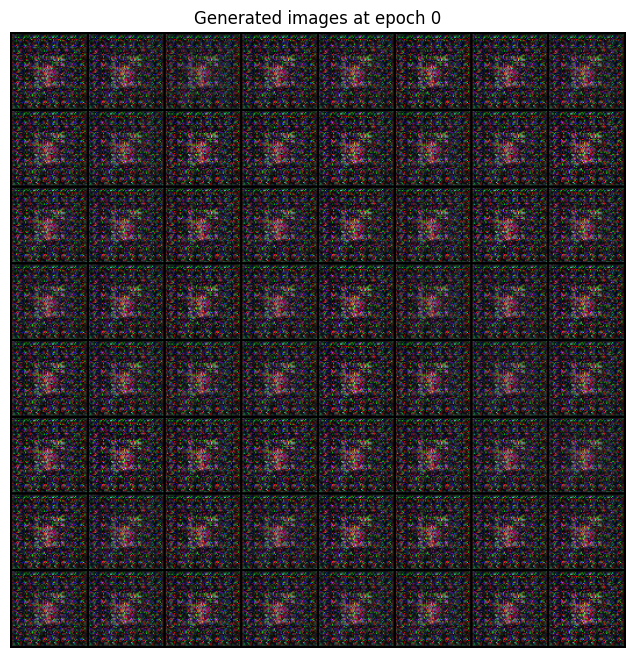

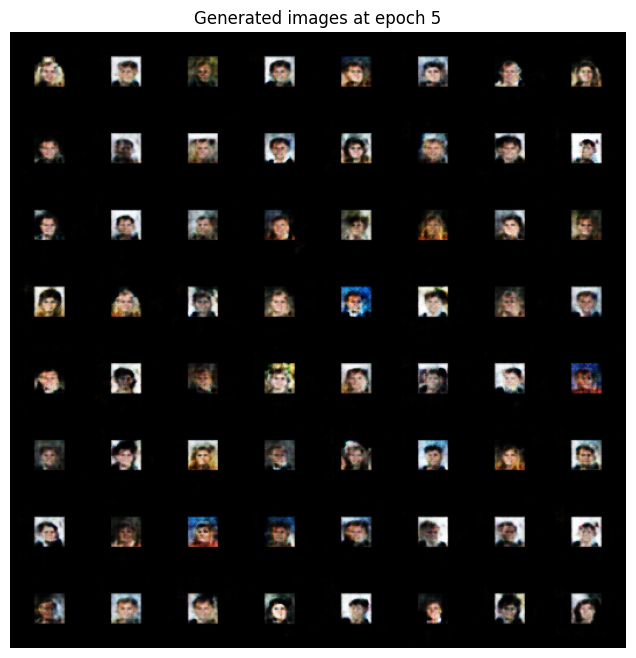

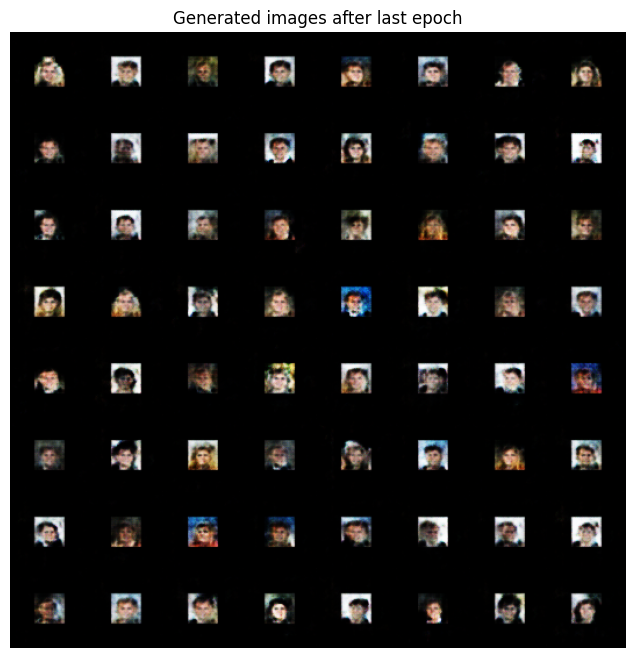

In [37]:
for i in range(0, NUM_EPOCHS, 5):

    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.title(f'Generated images at epoch {i}')
    plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][i], (1, 2, 0)))
    plt.show()


plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Generated images after last epoch')
plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][-1], (1, 2, 0)))
plt.show()

# Próximos Pasos

Como futuros pasos, se podría considerar la implementación de variantes más avanzadas de GAN, para abordar desafíos específicos en la generación de imágenes de caras de celebridades. Además, se podrían explorar técnicas de regularización y optimización para mejorar aún más la calidad de las imágenes generadas.

Este proyecto proporciona una base sólida para futuras investigaciones en la generación de imágenes realistas utilizando GANs y demuestra el potencial de aplicar técnicas de aprendizaje profundo en el campo de la visión por computadora.